In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import Lasso, LassoCV, RidgeCV, LinearRegression
import statsmodels.api as sm
from BayesianLasso import BayesianLasso

In [2]:
# Load Dataset

filename = "Data/training_data100x9.pickle"

with open(filename,"rb") as file:
    X_train, y_train = pickle.load(file)
    
# standardise X
X_train = (X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_train.shape, y_train.shape

((100, 9), (100, 1))

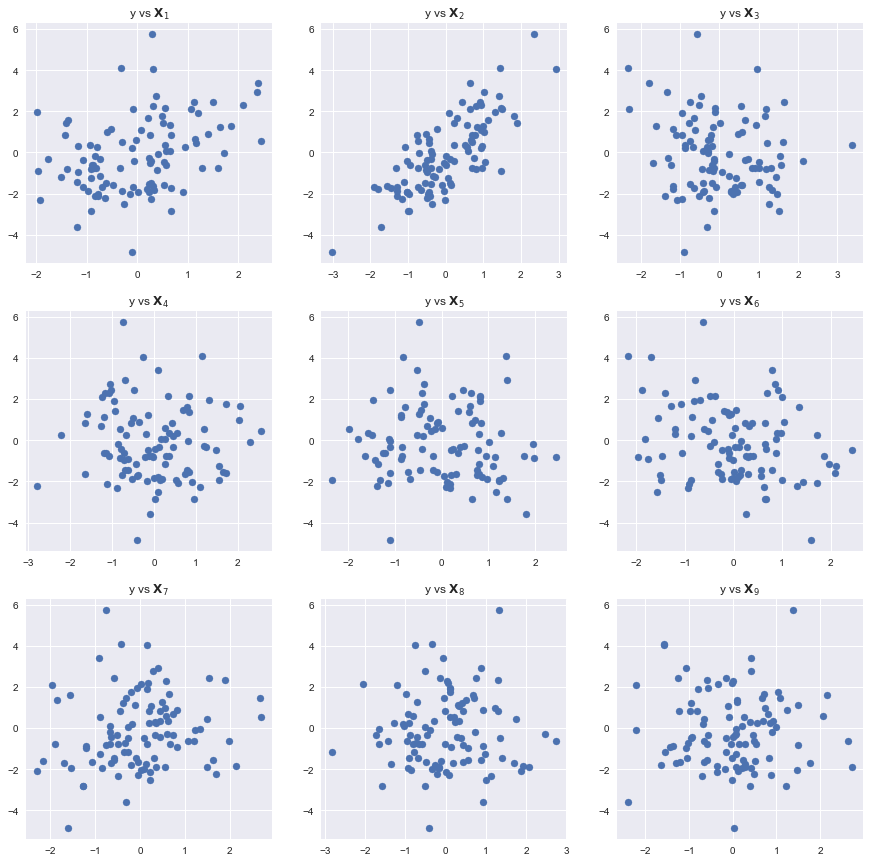

In [3]:
# First make some plots
# Don't use this plot in the report - use the one with OLS line on
plt.style.use("seaborn")
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15,15))
for row in range(1,4):
    for column in range(1,4):
        ax[row-1][column-1].scatter(X_train[:,3*(row-1)+column-1],y_train)
        ax[row-1][column-1].title.set_text(fr"y vs $\mathbf{{X}}_{{{3*(row-1)+column}}}$")
        
# Looks like potential linear correlations with beta1, beta2, beta 3 from the plot.

In [4]:
# Secondly, I find the OLS estimates using both scikit and statsmodels

# SciKit
skmodel = LinearRegression(fit_intercept=False)
skmodel.fit(X_train,y_train-np.mean(y_train))
print(skmodel.coef_)
# StatsModels
smModel = sm.OLS(y_train-np.mean(y_train),X_train).fit()
print(smModel.params)

[[ 6.06229388e-01  1.37770985e+00 -1.17397414e-01 -4.69662945e-02
  -8.97595171e-02 -1.07200448e-03  5.09208843e-02 -8.39111216e-02
  -4.75168789e-02]]
[ 6.06229388e-01  1.37770985e+00 -1.17397414e-01 -4.69662945e-02
 -8.97595171e-02 -1.07200448e-03  5.09208843e-02 -8.39111216e-02
 -4.75168789e-02]


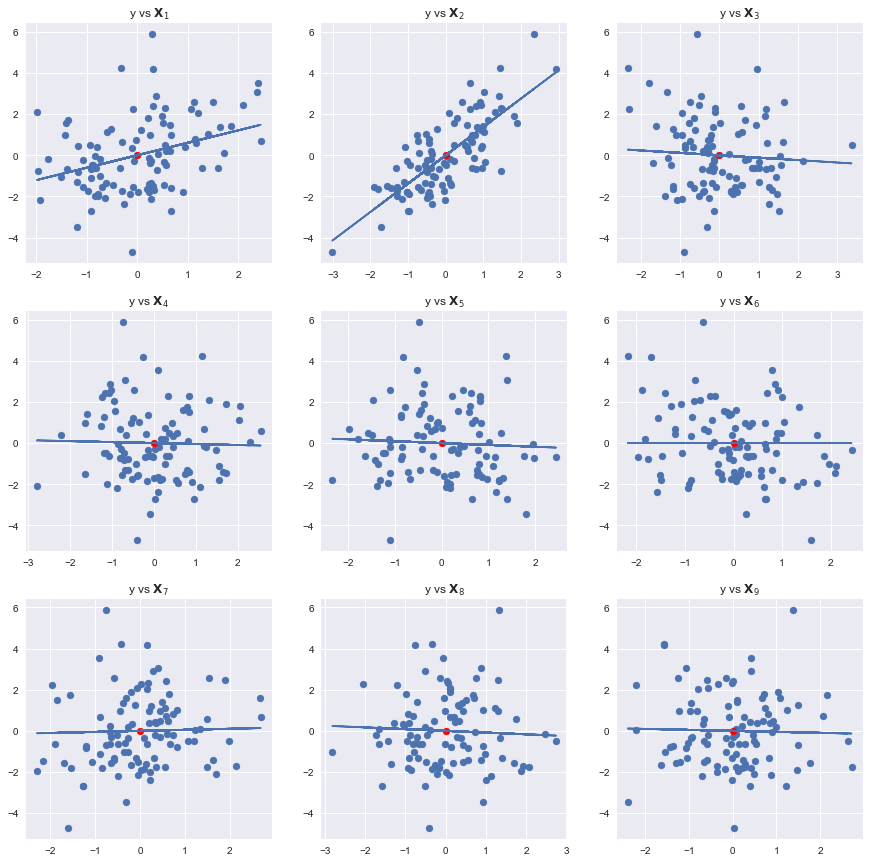

In [6]:
# Superimpose the best fit lines on the graphs
# Add these in report

plt.style.use("seaborn")
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15,15))
for row in range(1,4):
    for column in range(1,4):
        ax[row-1][column-1].scatter(X_train[:,3*(row-1)+column-1],y_train-np.mean(y_train))
        ax[row-1][column-1].plot(X_train[:,3*(row-1)+column-1], smModel.params[3*(row-1)+column-1]*X_train[:,3*(row-1)+column-1])
        ax[row-1][column-1].scatter(np.mean(X_train[:,3*(row-1)+column-1]),0,color="r")
        ax[row-1][column-1].title.set_text(fr"y vs $\mathbf{{X}}_{{{3*(row-1)+column}}}$")
        
plt.show()

y_hat = np.matmul(X_train,np.reshape(smModel.params,(-1,1)))

In [7]:
"""Set Jeffreys' Prior on \sigma^{2} and iid laplace conditional priors on the \boldsymbol{\beta}"""

"Set Jeffreys' Prior on \\sigma^{2} and iid laplace conditional priors on the \x08oldsymbol{\x08eta}"

In [8]:
# Run Gibbs Sampler for a given lambda

lam = 5.12

bayesianLasso = BayesianLasso(X_train,y_train)
beta_samplesLam, sig2_samplesLam, tau2_samplesLam = bayesianLasso.gibbs_fixedLam(lam,10000)

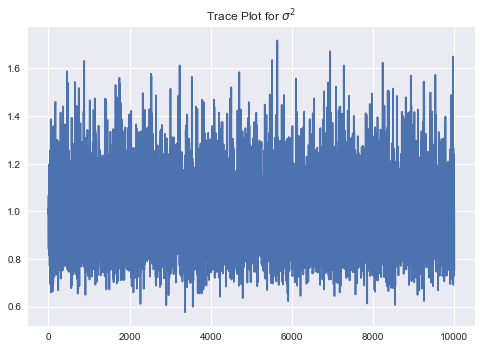

In [10]:
# Trace plot for Sigma^2
plt.title(r"Trace Plot for $\sigma^{2}$")
plt.plot(sig2_samplesLam)
plt.show()
# A burn in period of 2500 seems sufficient

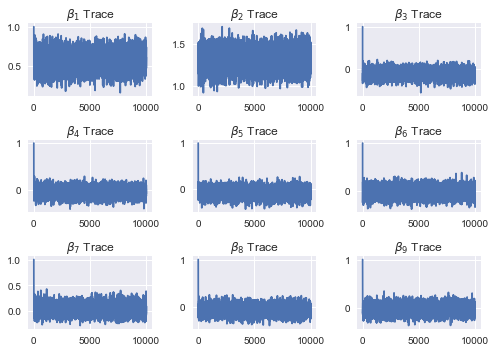

In [15]:
# Trace Plots for the Beta
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(7,5))

for i in range(1,4):
    for j in range(1,4):
        ax[i-1][j-1].plot(beta_samplesLam[:,3*(i-1)+j-1])
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{3*(i-1)+j}}}$ Trace")

plt.tight_layout()
plt.show()
# A burn in of 2500 seems good

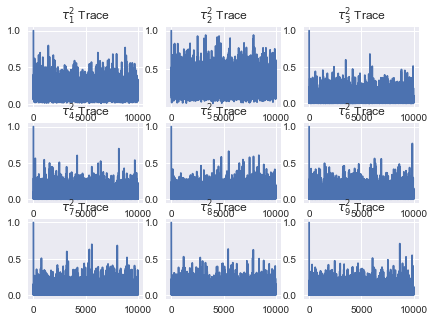

In [17]:
# Trace Plots for the Tau^2

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(7,5))

for i in range(1,4):
    for j in range(1,4):
        ax[i-1][j-1].plot(tau2_samplesLam[:,3*(i-1)+j-1])
        ax[i-1][j-1].title.set_text(fr"$\tau_{{{3*(i-1)+j}}}^{2}$ Trace")

plt.show()
# Again a burn in of 2500 seems good

In [18]:
burned_beta_tracesLam = beta_samplesLam[2500:,:]
burned_sig2_tracesLam = sig2_samplesLam[2500:]
burned_tau2_tracesLam = tau2_samplesLam[2500:,:]

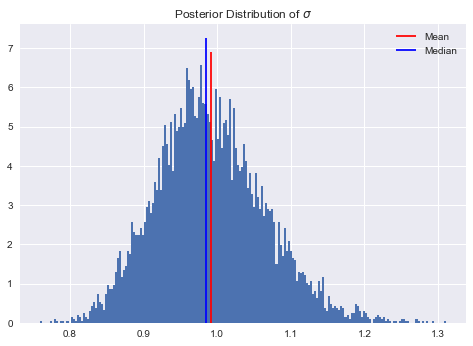

Mean: 0.9911610813297266
Median: 0.9854916355669987


In [19]:
# Histogram for Sigma^2

plt.title(r"Posterior Distribution of $\sigma$")
plt.hist(np.sqrt(burned_sig2_tracesLam),bins=200,density=True)
plt.vlines(np.mean(np.sqrt(burned_sig2_tracesLam)),0,plt.gca().get_ylim()[1],colors="r",label="Mean")
plt.vlines(np.median(np.sqrt(burned_sig2_tracesLam)),0,plt.gca().get_ylim()[1],colors="b",label="Median")
plt.legend(loc="upper right")
plt.show()

print(f"Mean: {np.mean(np.sqrt(burned_sig2_tracesLam))}")
print(f"Median: {np.median(np.sqrt(burned_sig2_tracesLam))}")

In [20]:
# I now calculate the frequentist Lasso estimates that SHOULD (theoretically) approximate the mode of the posterior distribution
# I check this using scikit and statsmodels

sigmamedian = np.median(np.sqrt(burned_sig2_tracesLam))
sigmamean = np.mean(np.sqrt(burned_sig2_tracesLam))
# Check with SciKit's Lasso 
lassomodel = Lasso(alpha=2*sigmamedian*lam/(2*len(y_train)),fit_intercept=False,tol=1e-10)
lassomodel.fit(X_train,y_train-np.mean(y_train))
print(lassomodel.coef_)

# StatsModel's Lasso
smLasso = sm.OLS(y_train-np.mean(y_train),X_train).fit_regularized(alpha=2*sigmamedian*lam/(2*len(y_train)))
print(smLasso.params)

[ 0.5763611   1.32418459 -0.08950231 -0.00797428 -0.04834706 -0.
  0.00796882 -0.03465118 -0.        ]
[ 0.5763611   1.32418459 -0.08950231 -0.00797428 -0.04834706  0.
  0.00796882 -0.03465118  0.        ]


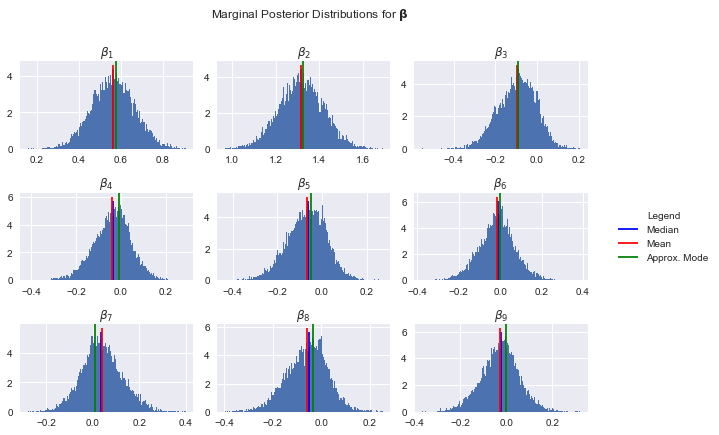

In [63]:
# Histograms for Beta, with medians, means plotted 
# Also plotted the Lasso estimates that should approximately be the mode of the posteriors

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(10,6))

for i in range(1,4):
    for j in range(1,4):
        ax[i-1][j-1].hist(burned_beta_tracesLam[:,3*(i-1)+j-1],bins=150,density=True)
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{3*(i-1)+j}}}$")
        ax[i-1][j-1].vlines(np.median(burned_beta_tracesLam,axis=0)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="b",label="Median")
        ax[i-1][j-1].vlines(np.mean(burned_beta_tracesLam,axis=0)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="r",label="Mean")
        ax[i-1][j-1].set_ylim()
        ax[i-1][j-1].vlines((smLasso.params)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="g",label="Approx. Mode")
        if ((i==2) and (j==3)):
            ax[i-1][j-1].legend(loc="center right",title="Legend",bbox_to_anchor=(1.75, 0.5))
        
fig.suptitle(r"Marginal Posterior Distributions for $\mathbf{\beta}$",x=0.435,y=1.0)       
plt.tight_layout()
plt.show()

# The symmetric distributions mean that the mode, mean and medians are really close
# But it does look like the frequentist estimates match the empirical mode of the posteriors.


In [68]:
"""Find maximum marginal likelihood estimate for lambda"""

lambdasMML,lambdaMML = bayesianLasso.lambda_MML(em_iter=20,gibbs_iter=9000)

In [69]:
lambdaMML

3.4670411196888464

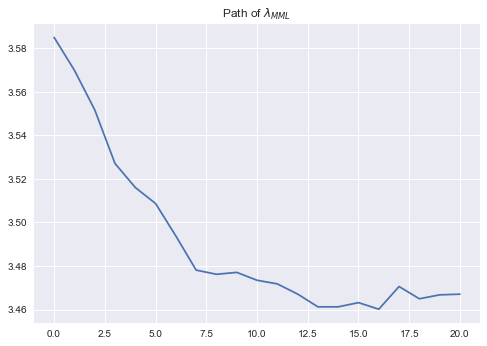

In [70]:
plt.title(r"Path of $\lambda_{MML}$")
plt.plot(lambdasMML)
plt.show()

In [71]:
# Run the Gibbs Sampler using this marginal maximum likelihood estimate
betatracesMML,sig2tracesMML,tau2tracesMML = bayesianLasso.gibbs_fixedLam(lambdaMML,20000)
burnedbetatracesMML, burnedsig2tracesMML, burnedtau2tracesMML = betatracesMML[2000:,:], sig2tracesMML[2000:], tau2tracesMML[2000:,:]

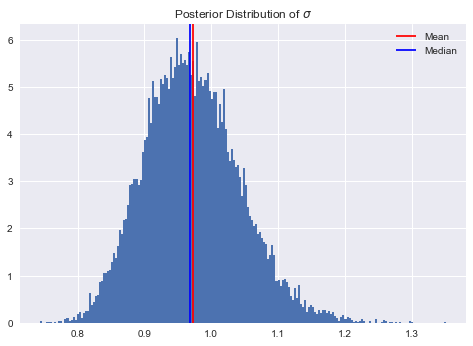

Mean: 0.9721365954492617
Median: 0.9678832834889329


In [72]:
# Histogram for Sigma

plt.title(r"Posterior Distribution of $\sigma$")
plt.hist(np.sqrt(burnedsig2tracesMML),bins=200,density=True)
plt.gca().set_ylim()
plt.vlines(np.mean(np.sqrt(burnedsig2tracesMML)),0,plt.gca().get_ylim()[1],colors="r",label="Mean")
plt.vlines(np.median(np.sqrt(burnedsig2tracesMML)),0,plt.gca().get_ylim()[1],colors="b",label="Median")
plt.legend(loc="upper right")
plt.show()

print(f"Mean: {np.mean(np.sqrt(burnedsig2tracesMML))}")
print(f"Median: {np.median(np.sqrt(burnedsig2tracesMML))}")

In [73]:
# I now calculate the frequentist Lasso estimates that SHOULD approximate the mode of the posterior distribution for beta

sigmamedianMML = np.median(np.sqrt(burnedsig2tracesMML))

lassomodel = Lasso(alpha=2*sigmamedianMML*lambdaMML/(2*len(y_train)),fit_intercept=False,tol=1e-12)
lassomodel.fit(X_train,y_train-np.mean(y_train))
print(lassomodel.coef_)

smLasso = sm.OLS(y_train-np.mean(y_train),X_train).fit_regularized(alpha=2*sigmamedianMML*lambdaMML/(2*len(y_train)))
print(smLasso.params)

[ 0.58762665  1.34174844 -0.09981472 -0.02116065 -0.05889214 -0.
  0.02194153 -0.05034243 -0.00310999]
[ 0.58762665  1.34174844 -0.09981472 -0.02116065 -0.05889214  0.
  0.02194153 -0.05034243 -0.00310999]


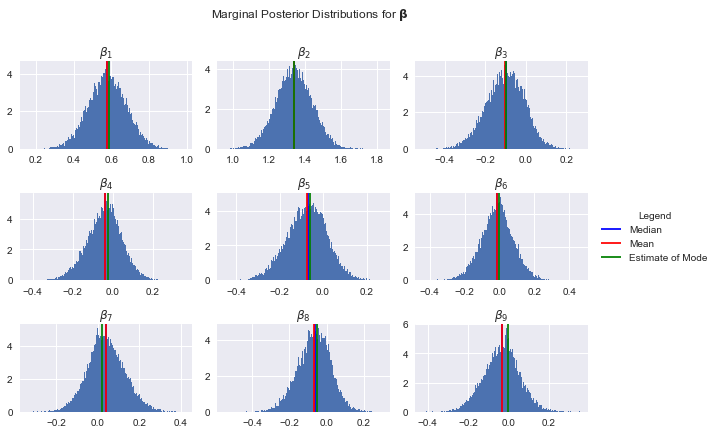

In [77]:
# Histograms for Beta
# Also plotted the frequentist Lasso estimates that theoretically should be the mode of the posteriors

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(10,6))

for i in range(1,4):
    for j in range(1,4):
        ax[i-1][j-1].hist(burnedbetatracesMML[:,3*(i-1)+j-1],bins=200,density=True)
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{3*(i-1)+j}}}$")
        ax[i-1][j-1].set_ylim()
        ax[i-1][j-1].vlines(np.median(burnedbetatracesMML,axis=0)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="b",label="Median")
        ax[i-1][j-1].vlines(np.mean(burnedbetatracesMML,axis=0)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="r",label="Mean")
        ax[i-1][j-1].vlines(lassomodel.coef_[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="g",label="Estimate of Mode")
        if ((i==2) and (j==3)):
            ax[i-1][j-1].legend(loc="center right",title="Legend",bbox_to_anchor=(1.75, 0.5))
            
fig.suptitle(r"Marginal Posterior Distributions for $\mathbf{\beta}$",x=0.435,y=1.0) 
plt.tight_layout()
plt.show()

In [256]:
linearModel = sm.OLS(y_train-np.mean(y_train),X_train).fit()
s2 = np.sum(linearModel.resid**2)/(100-9)

rescaledLambdaCV = lambdaCV/(2*np.sqrt(s2))

# Run the Gibbs Sampler using the cross validation lambda estimate
betatracesCV,sig2tracesCV,tau2tracesCV = bayesianLasso.gibbs_fixedLam(rescaledLambdaCV,20000)
burnedbetatracesCV, burnedsig2tracesCV, burnedtau2tracesCV = betatracesCV[2000:,:], sig2tracesCV[2000:], tau2tracesCV[2000:,:]


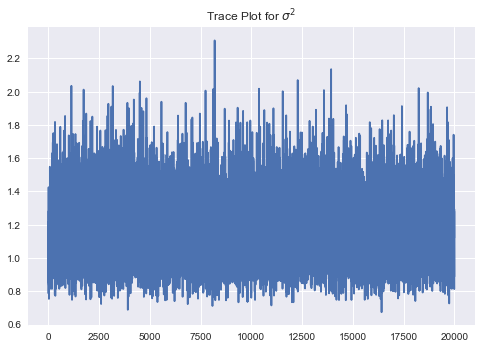

In [257]:
# Trace plot for Sigma^2
plt.title(r"Trace Plot for $\sigma^{2}$")
plt.plot(sig2tracesCV)
plt.show()
# A burn in period of 2500 seems sufficient

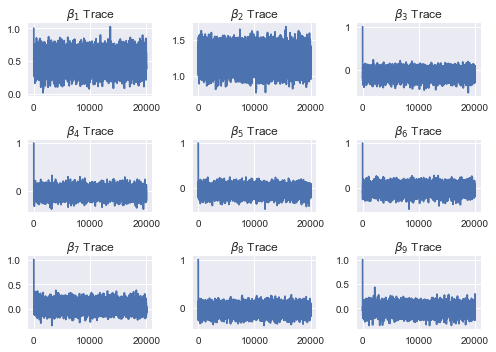

In [258]:
# Trace Plots for the Beta
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(7,5))

for i in range(1,4):
    for j in range(1,4):
        ax[i-1][j-1].plot(betatracesCV[:,3*(i-1)+j-1])
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{3*(i-1)+j}}}$ Trace")

plt.tight_layout()
plt.show()
# A burn in of 2500 seems good

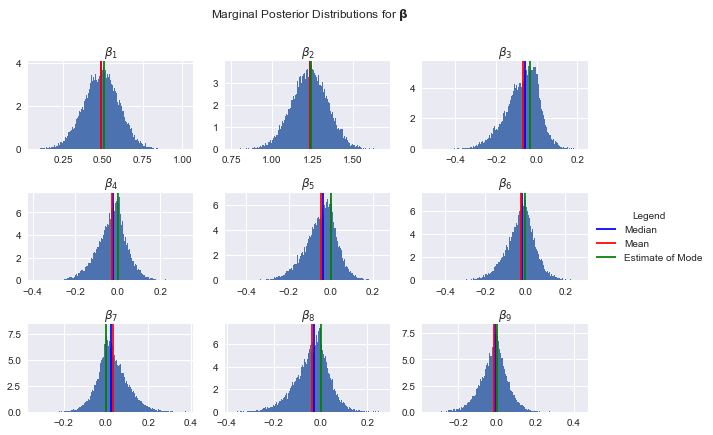

In [262]:
# Histograms for Beta
# Also plotted the frequentist Lasso estimates that theoretically should be the mode of the posteriors

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(10,6))


sigmamedianCV = np.median(np.sqrt(burnedsig2tracesCV))

lassomodel = Lasso(alpha=2*sigmamedianCV*rescaledLambdaCV/(2*len(y_train)),fit_intercept=False,tol=1e-12)
lassomodel.fit(X_train,y_train-np.mean(y_train))

for i in range(1,4):
    for j in range(1,4):
        ax[i-1][j-1].hist(burnedbetatracesCV[:,3*(i-1)+j-1],bins=200,density=True)
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{3*(i-1)+j}}}$")
        ax[i-1][j-1].set_ylim()
        ax[i-1][j-1].vlines(np.median(burnedbetatracesCV,axis=0)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="b",label="Median")
        ax[i-1][j-1].vlines(np.mean(burnedbetatracesCV,axis=0)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="r",label="Mean")
        ax[i-1][j-1].vlines(lassomodel.coef_[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="g",label="Estimate of Mode")
        if ((i==2) and (j==3)):
            ax[i-1][j-1].legend(loc="center right",title="Legend",bbox_to_anchor=(1.75, 0.5))
            
fig.suptitle(r"Marginal Posterior Distributions for $\mathbf{\beta}$",x=0.435,y=1.0) 
plt.tight_layout()
plt.show()

In [78]:
"""Make regularisation plots"""

# (1) First plot paths of Posterior Median, Posterior Mean and Lasso estimates with lambda
lambdas = np.linspace(0.1,400,80)
lambdaBetaMedians = np.zeros((len(lambdas),9)) # Matrix of (lambda,posterior medians)
lambdaBetaMeans = np.zeros((len(lambdas),9)) # Matrix of (lambda,posterior means)

for idx, lam in enumerate(lambdas):
    betaTraces, sig2Traces, tau2Traces = bayesianLasso.gibbs_fixedLam(lam,n_iter=5000)
    burnedBetaTraces = betaTraces[2000:,:]
    lambdaBetaMedians[idx,:] = np.reshape(np.median(burnedBetaTraces,axis=0),(1,-1))
    lambdaBetaMeans[idx,:] = np.reshape(np.mean(burnedBetaTraces,axis=0),(1,-1))

In [79]:
freqLassoPath = np.zeros((len(lambdas),9))
smLasso = sm.OLS(y_train-np.mean(y_train),X_train)

for idx in range(len(lambdas)):
    freqLassoPath[idx,:] = smLasso.fit_regularized(alpha=lambdas[idx]/(2*X_train.shape[0])).params

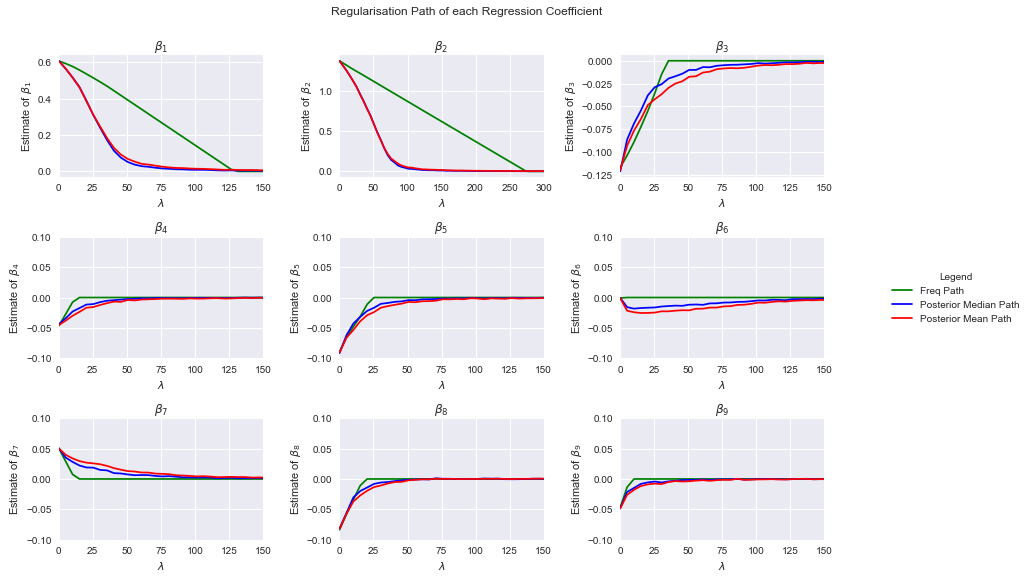

In [98]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15,8))
fig.suptitle("Regularisation Path of each Regression Coefficient",x=0.435,y=1.0)
for row in range(1,4):
    for column in range(1,4):
        ax[row-1][column-1].set_title(fr"$\beta_{{{3*(row-1)+column}}}$")
        ax[row-1][column-1].set_xlabel(r"$\lambda$")
        ax[row-1][column-1].set_ylabel(fr"Estimate of $\beta_{{{3*(row-1)+column}}}$")
        ax[row-1][column-1].plot(lambdas,freqLassoPath[:,3*(row-1)+column-1],color="g",label="Freq Path")
        ax[row-1][column-1].plot(lambdas,lambdaBetaMedians[:,3*(row-1)+column-1],color="b",label="Posterior Median Path")
        ax[row-1][column-1].plot(lambdas,lambdaBetaMeans[:,3*(row-1)+column-1],color="r",label="Posterior Mean Path")
        if (3*(row-1)+column-1) >=3:
            ax[row-1][column-1].set_ylim(-0.1,0.1)
        if ((row==1) and (column==2)):
            ax[row-1][column-1].set_xlim(0,300)
        else:
            ax[row-1][column-1].set_xlim(0,150)
        if ((row==2) and (column==3)):
            ax[row-1][column-1].legend(loc="center right",title="Legend",bbox_to_anchor=(2, 0.5))
        
plt.tight_layout()
plt.show()

# Want to justify why lambda=400 in plots. 
# Wanted to see Beta2 go to zero, simulated dataset suggests strong correlation
# thats why it took longer to go to zero.

In [81]:
# (2) Regularisation paths as a function of relative L1 norm, for posterior median, lasso, ridge, posterior mean
lambdal1BetaMedians = np.linalg.norm(lambdaBetaMedians,1,axis=1)
relativel1BetaMedians = lambdal1BetaMedians/np.max(lambdal1BetaMedians)

lambdal1BetaMeans = np.linalg.norm(lambdaBetaMeans,1,axis=1)
relativel1BetaMeans = lambdal1BetaMeans/np.max(lambdal1BetaMeans)

lambdal1BetaModes = np.linalg.norm(freqLassoPath,1,axis=1)
relativel1BetaModes = lambdal1BetaModes/np.max(lambdal1BetaModes)

In [82]:
# Want to superimpose vertical lines for lambda chosen by MML for posterior summaries, lambda chosen by CV for lasso, ridge

In [83]:
# Find lambda for the frequentist lasso chosen by cross validation

lassoCVmodel = LassoCV(cv=10,fit_intercept=False,tol=1e-12)
lassoCVmodel.fit(X_train,np.ravel(y_train-np.mean(y_train)))

l1betaCV = np.linalg.norm(lassoCVmodel.coef_,1)
print("Smallest lambda tested in CV is:",min(lassoCVmodel.alphas_)*2*X_train.shape[0])
print("Largest lambda tested in CV is:",max(lassoCVmodel.alphas_)*2*X_train.shape[0])
print("Number of lambdas tested in CV is:", len(lassoCVmodel.alphas_))
print("Lambda chosen by cross-validation is:", lassoCVmodel.alpha_*2*X_train.shape[0])
print("L1 Norm of the betas with lambda chosen by CV is:", l1betaCV)

Smallest lambda tested in CV is: 0.2743882284076939
Largest lambda tested in CV is: 274.38822840769393
Number of lambdas tested in CV is: 100
Lambda chosen by cross-validation is: 23.864888798765232
L1 Norm of the betas with lambda chosen by CV is: 1.8148346387911156


In [84]:
# Calculate Ridge paths
ridgeLambdas = np.linspace(0.1,5000,200)
smRidge = sm.OLS(y_train-np.mean(y_train),X_train)
freqRidgePath = np.zeros((len(ridgeLambdas),9))
for idx in range(len(ridgeLambdas)):
    freqRidgePath[idx,:] = smRidge.fit_regularized(alpha=ridgeLambdas[idx]/(X_train.shape[0]),L1_wt=0).params
    
lambdal1BetaRidge = np.linalg.norm(freqRidgePath,1,axis=1)
relativel1BetaRidge = lambdal1BetaRidge/np.max(lambdal1BetaRidge)

# Find lambda for the frequentist ridge chosen by cross validation

ridgeCVmodel = RidgeCV(cv=10,fit_intercept=False,alphas=lassoCVmodel.alphas_*10)
ridgeCVmodel.fit(X_train,np.ravel(y_train-np.mean(y_train)))

l1betaridgeCV = np.linalg.norm(ridgeCVmodel.coef_,1)

In [85]:
# Find relative l1 norm of beta medians and means for lambdaMML
l1betamedianMML = np.linalg.norm(np.median(burnedbetatracesMML,axis=0),1)
l1betameanMML = np.linalg.norm(np.mean(burnedbetatracesMML,axis=0),1)

relativel1betamedianMML = l1betamedianMML/np.max(lambdal1BetaMedians)
relativel1betameanMML = l1betameanMML/np.max(lambdal1BetaMeans)

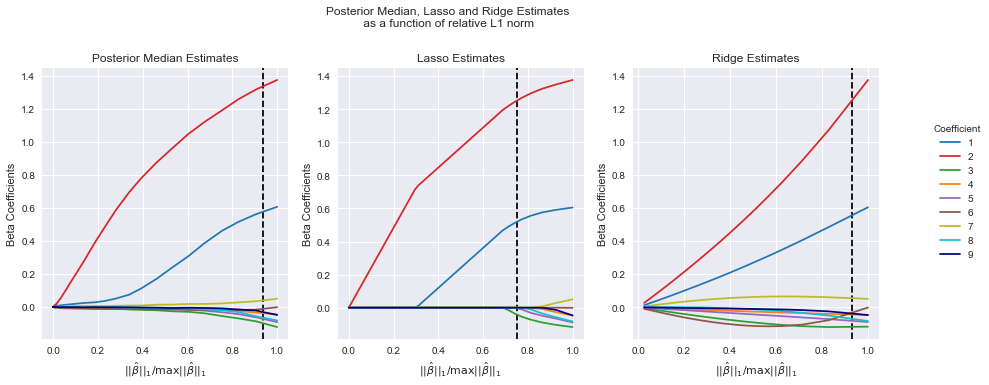

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
colors = ["tab:blue","tab:red","tab:green","tab:orange","tab:purple","tab:brown","tab:olive","tab:cyan","navy"]

# First plot Bayesian Lasso median estimates
ax[0].set_xlabel(r"$||\^{\beta}||_{1}/\max{||\^{\beta}||_{1}}$")
ax[0].set_ylabel("Beta Coefficients")
ax[0].set_title("Posterior Median Estimates")
for idx,color in enumerate(colors):
    ax[0].plot(relativel1BetaMedians,lambdaBetaMedians[:,idx],color=color,label=f"{idx+1}")
ax[0].set_ylim()
ax[0].vlines(relativel1betamedianMML,ax[0].get_ylim()[0],ax[0].get_ylim()[1],linestyle="--",colors="0")

# Now plot Lasso estimates
ax[1].set_xlabel(r"$||\^{\beta}||_{1}/\max{||\^{\beta}||_{1}}$")
ax[1].set_ylabel("Beta Coefficients")
ax[1].set_title("Lasso Estimates")

for idx,color in enumerate(colors):
    ax[1].plot(relativel1BetaModes,freqLassoPath[:,idx],color=color,label=f"{idx+1}")
ax[1].set_ylim()
ax[1].vlines(l1betaCV/np.max(lambdal1BetaModes),ax[1].get_ylim()[0],ax[1].get_ylim()[1],linestyle="--",colors="0")

# Now plot Ridge estimates
ax[2].set_xlabel(r"$||\^{\beta}||_{1}/\max{||\^{\beta}||_{1}}$")
ax[2].set_ylabel("Beta Coefficients")
ax[2].set_title("Ridge Estimates")

for idx,color in enumerate(colors):
    ax[2].plot(relativel1BetaRidge,freqRidgePath[:,idx],color=color,label=f"{idx+1}")
    if idx==8:
        handles, labels = ax[2].get_legend_handles_labels()
        fig.legend(handles, labels, loc='center right',title="Coefficient")    
ax[2].set_ylim()
ax[2].vlines(l1betaridgeCV/np.max(lambdal1BetaRidge),ax[2].get_ylim()[0],ax[2].get_ylim()[1],linestyle="--",colors="0")
fig.suptitle("Posterior Median, Lasso and Ridge Estimates\n as a function of relative L1 norm",y=1.05)
plt.show()

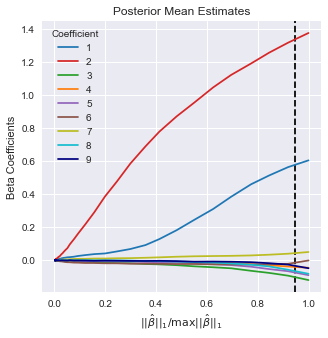

In [87]:
# Lastly do a similar plot for posterior mean

plt.figure(figsize=(5,5))
plt.title("Posterior Mean Estimates")
plt.xlabel(r"$||\^{\beta}||_{1}/\max{||\^{\beta}||_{1}}$")
plt.ylabel("Beta Coefficients")

for idx,color in enumerate(colors):
    plt.plot(relativel1BetaMeans,lambdaBetaMeans[:,idx],color=color,label=f"{idx+1}")

plt.gca().set_ylim()
plt.vlines(relativel1betameanMML,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],linestyle="--",colors="0")
plt.legend(title="Coefficient")
plt.show()

# Very similar

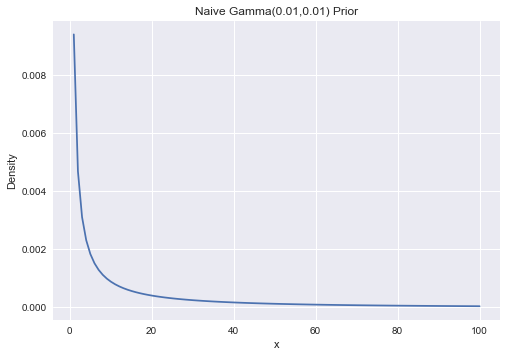

In [200]:
""" Now we investigate different priors on lambda^{2}"""

# (1) Naive Gamma prior with r = 0.01, delta = 0.01
# This gamma distribution has mean 1 and variance 100
# Large mass around smaller lambdas, as well as allowing for possible larger values - relatively flat

plt.title("Naive Gamma(0.01,0.01) Prior")
x = np.linspace(0,100,100)
plt.plot(x,stats.gamma.pdf(x,0.01,scale=1/0.01))
plt.xlabel("x")
plt.ylabel("Density")
plt.show()

In [176]:
bayesianLasso = BayesianLasso(X_train,y_train)
beta_tracesNaive, sig2_tracesNaive, tau2_tracesNaive, lambda_tracesNaive = bayesianLasso.gibbs_gammaHPrior(n_iter=10000)

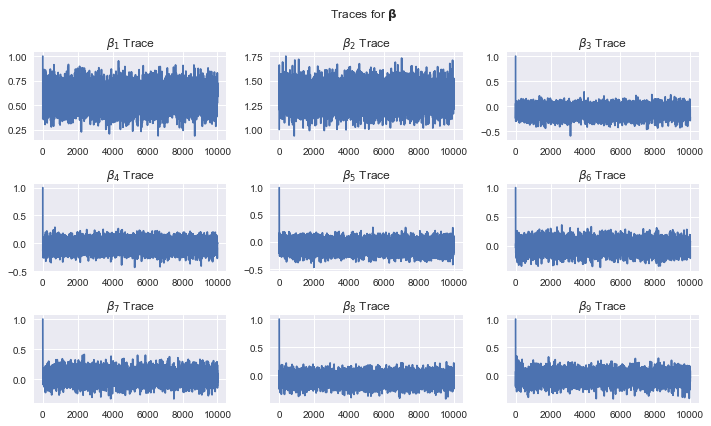

In [178]:
# Trace Plots for the Beta
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(10,6))

for i in range(1,4):
    for j in range(1,4):
        ax[i-1][j-1].plot(beta_tracesNaive[:,3*(i-1)+j-1])
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{3*(i-1)+j}}}$ Trace")
            
fig.suptitle(r"Traces for $\mathbf{\beta}$",x=0.51) 
plt.tight_layout()
# Again a burn in of 1000 seems good

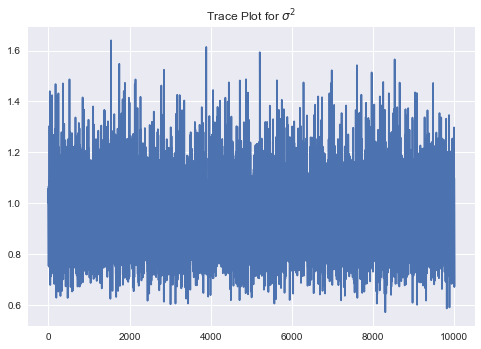

In [179]:
# Trace plot for Sigma^2
plt.title(r"Trace Plot for $\sigma^{2}$")
plt.plot(sig2_tracesNaive)
plt.show()
# A burn in period of 2000 seems sufficient

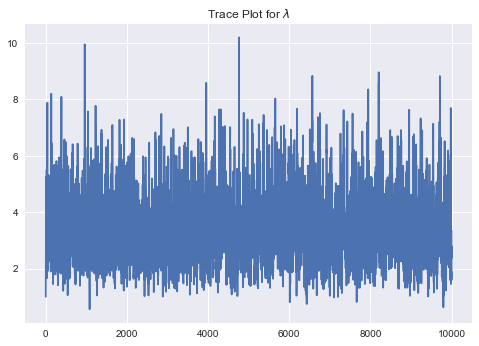

In [180]:
# Trace plot for Lambda
plt.title(r"Trace Plot for $\lambda$")
plt.plot(lambda_tracesNaive)
plt.show()
# A burn in period of 2000 seems sufficient

In [181]:
burned_naiveBeta = beta_tracesNaive[2000:,:]
burned_naiveSig2 = sig2_tracesNaive[2000:]
burned_naiveTau2 = tau2_tracesNaive[2000:,:]
burned_naiveLambda = lambda_tracesNaive[2000:]

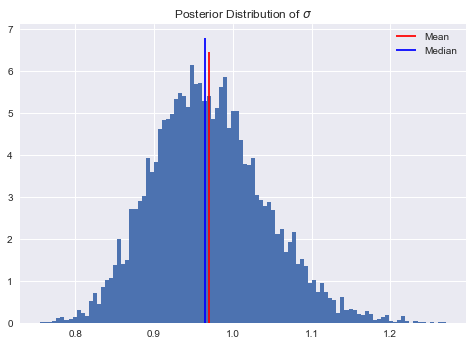

Mean: 0.9697997336255095
Median: 0.9650272539581722


In [182]:
# Histogram for Sigma

plt.title(r"Posterior Distribution of $\sigma$")
plt.hist(np.sqrt(burned_naiveSig2),bins=100,density=True)
plt.vlines(np.mean(np.sqrt(burned_naiveSig2)),0,plt.gca().get_ylim()[1],colors="r",label="Mean")
plt.vlines(np.median(np.sqrt(burned_naiveSig2)),0,plt.gca().get_ylim()[1],colors="b",label="Median")
plt.legend(loc="upper right")
plt.show()

print(f"Mean: {np.mean(np.sqrt(burned_naiveSig2))}")
print(f"Median: {np.median(np.sqrt(burned_naiveSig2))}")

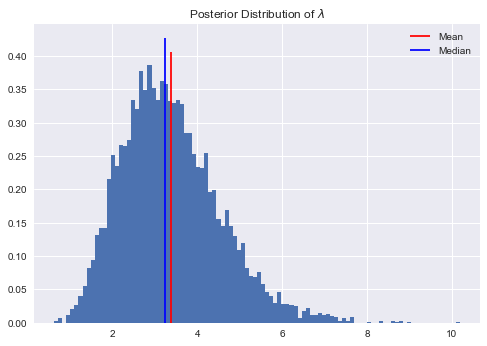

Mean: 3.379498551484471
Median: 3.2490705892238996


In [183]:
# Histogram for Lambda

plt.title(r"Posterior Distribution of $\lambda$")
plt.hist(burned_naiveLambda,bins=100,density=True)
plt.vlines(np.mean(burned_naiveLambda),0,plt.gca().get_ylim()[1],colors="r",label="Mean")
plt.vlines(np.median(burned_naiveLambda),0,plt.gca().get_ylim()[1],colors="b",label="Median")
plt.legend(loc="upper right")
plt.show()

print(f"Mean: {np.mean(burned_naiveLambda)}")
print(f"Median: {np.median(burned_naiveLambda)}")

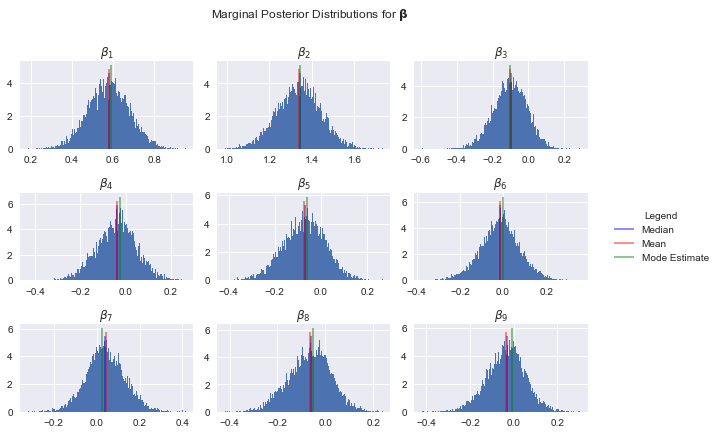

In [185]:
# Histograms for Beta, with medians, means plotted 
# Also plotted the frequentist Lasso estimates that theoretically should be the mode of the posteriors
# Explain why we use median lambda and sigma

sigmamedian = np.median(np.sqrt(burned_naiveSig2))
lambdamedian = np.median(burned_naiveLambda)

smLasso = sm.OLS(y_train-np.mean(y_train),X_train)

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(10,6))

for i in range(1,4):
    for j in range(1,4):
        ax[i-1][j-1].hist(burned_naiveBeta[:,3*(i-1)+j-1],bins=200,density=True)
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{3*(i-1)+j}}}$")
        ax[i-1][j-1].vlines(np.median(burned_naiveBeta,axis=0)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="b",label="Median",alpha=0.5)
        ax[i-1][j-1].vlines(np.mean(burned_naiveBeta,axis=0)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="r",label="Mean",alpha=0.5)
        ax[i-1][j-1].vlines((smLasso.fit_regularized(alpha=lambdamedian*2*sigmamedian/(2*len(y_train))).params)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="g",label="Mode Estimate",alpha=0.5)
        if ((i==2) and (j==3)):
            ax[i-1][j-1].legend(loc="center right",title="Legend",bbox_to_anchor=(1.75, 0.5))

fig.suptitle(r"Marginal Posterior Distributions for $\mathbf{\beta}$",x=0.435,y=1.0)
plt.tight_layout()        
plt.show()

# The symmetric distributions mean that the mode, mean and medians are really close
# But it does look like the frequentist estimates match the empirical mode of the posteriors.

In [186]:
naiveBetaPosteriorMedians = np.median(burned_naiveBeta,axis=0)
naiveBetaPosteriorMedians

array([ 0.57918836,  1.34134294, -0.09965826, -0.03730561, -0.06933236,
       -0.01200373,  0.03864135, -0.06049147, -0.03018136])

MML estimate of lambda: 3.4670411196888464


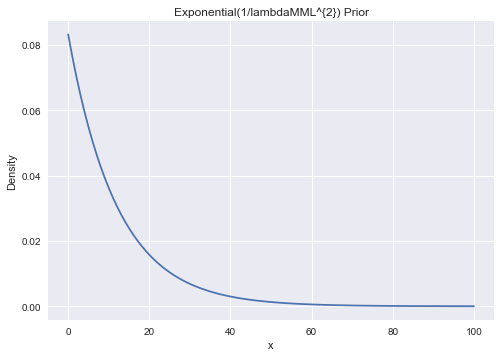

In [235]:
# (2) Exponential prior (r=1 in gamma prior) with mean equal to the square of the MML estimate
# we need mean = 1/delta = lambdaMML^2, so delta = 1/lambdaMML^2
# variance = 1/delta^2 = 1/(1/lambdaMML^4)=lambdaMML^4. If lambdaMML > 1, then the variance large. lambdaMML < 1, won't vary much
print("MML estimate of lambda:", lambdaMML)


plt.title("Exponential(1/lambdaMML^{2}) Prior")
x = np.linspace(0,100,100)
plt.plot(x,stats.expon.pdf(x,scale=lambdaMML**2))
plt.xlabel("x")
plt.ylabel("Density")
plt.show()

In [189]:
beta_tracesExpMML, sig2_tracesExpMML, tau2_tracesExpMML, lambda_tracesExpMML = bayesianLasso.gibbs_gammaHPrior(r = 1, delta = 1/(lambdaMML**2), n_iter=10000)

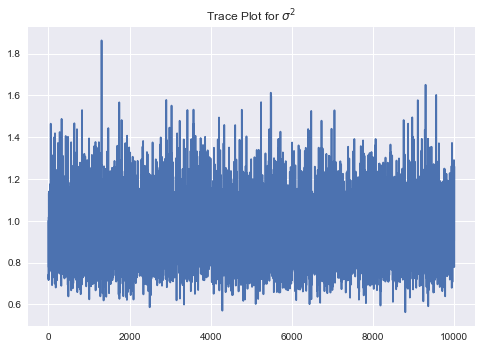

In [190]:
# Trace plot for Sigma^2
plt.title(r"Trace Plot for $\sigma^{2}$")
plt.plot(sig2_tracesExpMML)
plt.show()
# A burn in period of 2000 seems sufficient

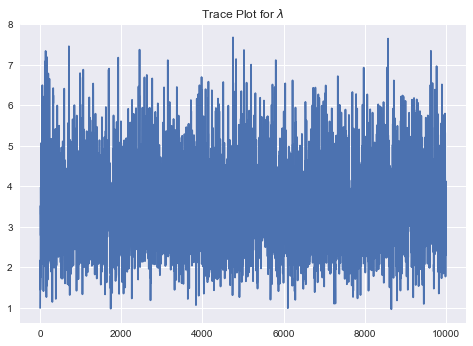

In [191]:
# Trace plot for Lambda
plt.title(r"Trace Plot for $\lambda$")
plt.plot(lambda_tracesExpMML)
plt.show()
# A burn in period of 2000 seems sufficient

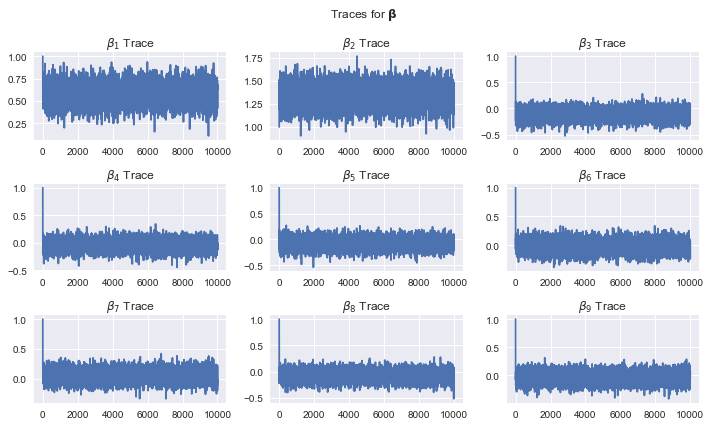

In [192]:
# Trace Plots for the Beta
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(10,6))

for i in range(1,4):
    for j in range(1,4):
        ax[i-1][j-1].plot(beta_tracesExpMML[:,3*(i-1)+j-1])
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{3*(i-1)+j}}}$ Trace")

fig.suptitle(r"Traces for $\mathbf{\beta}$",x=0.51) 
plt.tight_layout()
plt.show()
# Again a burn in of 1000 seems good

In [193]:
burned_BetaExpMML = beta_tracesExpMML[2000:,:]
burned_Sig2ExpMML = sig2_tracesExpMML[2000:]
burned_Tau2ExpMML = tau2_tracesExpMML[2000:,:]
burned_LambdaExpMML = lambda_tracesExpMML[2000:]

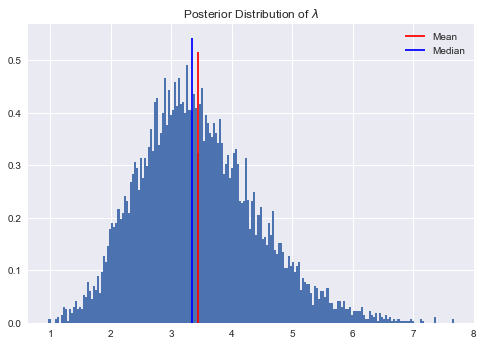

Mean: 3.441563153259491
Median: 3.3475467937717394


In [194]:
# Histogram for Lambda

plt.title(r"Posterior Distribution of $\lambda$")
plt.hist(burned_LambdaExpMML,bins=200,density=True)
plt.vlines(np.mean(burned_LambdaExpMML),0,plt.gca().get_ylim()[1],colors="r",label="Mean")
plt.vlines(np.median(burned_LambdaExpMML),0,plt.gca().get_ylim()[1],colors="b",label="Median")
plt.legend(loc="upper right")
plt.show()

print(f"Mean: {np.mean(burned_LambdaExpMML)}")
print(f"Median: {np.median(burned_LambdaExpMML)}")

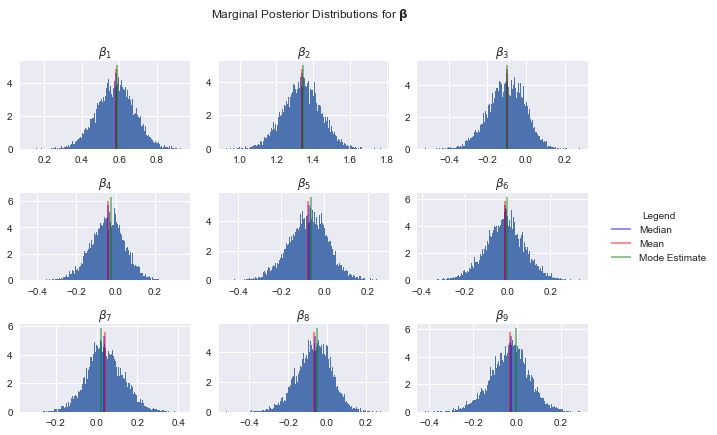

In [196]:
# Histograms for Beta, with medians, means plotted 
# Also plotted the frequentist Lasso estimates that theoretically should be the mode of the posteriors
sigmamedian = np.median(np.sqrt(burned_Sig2ExpMML))
lambdamedian = np.median(burned_LambdaExpMML)

smLasso = sm.OLS(y_train-np.mean(y_train),X_train)
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(10,6))

for i in range(1,4):
    for j in range(1,4):
        ax[i-1][j-1].hist(burned_BetaExpMML[:,3*(i-1)+j-1],bins=200,density=True)
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{3*(i-1)+j}}}$")
        ax[i-1][j-1].vlines(np.median(burned_BetaExpMML,axis=0)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="b",label="Median",alpha=0.5)
        ax[i-1][j-1].vlines(np.mean(burned_BetaExpMML,axis=0)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="r",label="Mean",alpha=0.5)
        ax[i-1][j-1].vlines((smLasso.fit_regularized(alpha=lambdamedian*2*sigmamedian/(2*len(y_train))).params)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="g",label="Mode Estimate",alpha=0.5)
        if ((i==2) and (j==3)):
            ax[i-1][j-1].legend(loc="center right",title="Legend",bbox_to_anchor=(1.75, 0.5))

fig.suptitle(r"Marginal Posterior Distributions for $\mathbf{\beta}$",x=0.435,y=1.0)
plt.tight_layout()        
plt.show()

# The symmetric distributions mean that the mode, mean and medians are really close
# But it does look like the frequentist estimates match the empirical mode of the posteriors.

In [214]:
expMMLBetaPosteriorMedians = np.median(burned_BetaExpMML,axis=0)
expMMLBetaPosteriorMedians

array([ 0.581231  ,  1.3398086 , -0.09824312, -0.03843004, -0.07048596,
       -0.00974562,  0.0378543 , -0.06148871, -0.02937722])

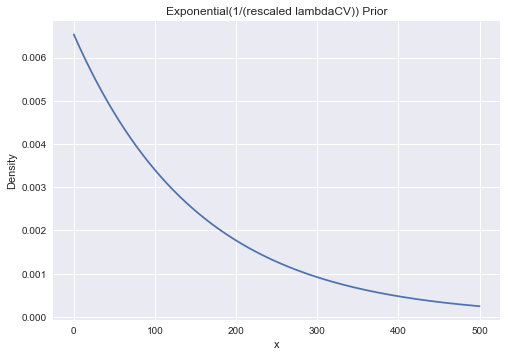

In [203]:
# (3) Exponential prior (r=1 in gamma prior) with mean equal to the square of the rescaled CV estimate
# so lambdaCV \approx 2*s*lam -> choose lam = lambdaCV/2s where s is the estimated std of errors from OLS
# we need mean = 1/delta = lam^{2}, so delta = 1/lam^{2}
# variance = 1/delta^2 = lam^4. If lam > 1, then the variance large. lambdaMML < 1, won't vary much
lambdaCV = lassoCVmodel.alpha_*2*X_train.shape[0]
s2 = np.sum(smModel.resid**2)/(100-9)
lam = lambdaCV/(2*np.sqrt(s2))

plt.title("Exponential(1/(rescaled lambdaCV)) Prior")
plt.plot(np.linspace(0,500,1000),stats.expon.pdf(np.linspace(0,500,1000),scale=lam**2))
plt.ylabel("Density")
plt.xlabel("x")
plt.show()

In [204]:
beta_tracesLamCV, sig2_tracesLamCV, tau2_tracesLamCV, lambda_tracesLamCV = bayesianLasso.gibbs_gammaHPrior(r = 1, delta = 1/(lam**2), n_iter=10000)

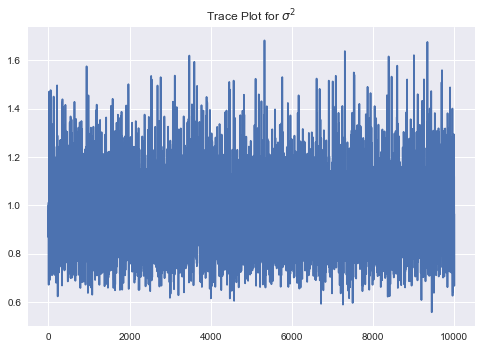

In [205]:
# Trace plot for Sigma^2
plt.title(r"Trace Plot for $\sigma^{2}$")
plt.plot(sig2_tracesLamCV)
plt.show()
# A burn in period of 2000 seems sufficient

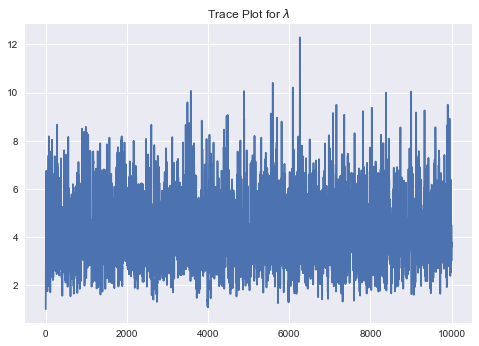

In [206]:
# Trace plot for Lambda
plt.title(r"Trace Plot for $\lambda$")
plt.plot(lambda_tracesLamCV)
plt.show()
# A burn in period of 2000 seems sufficient

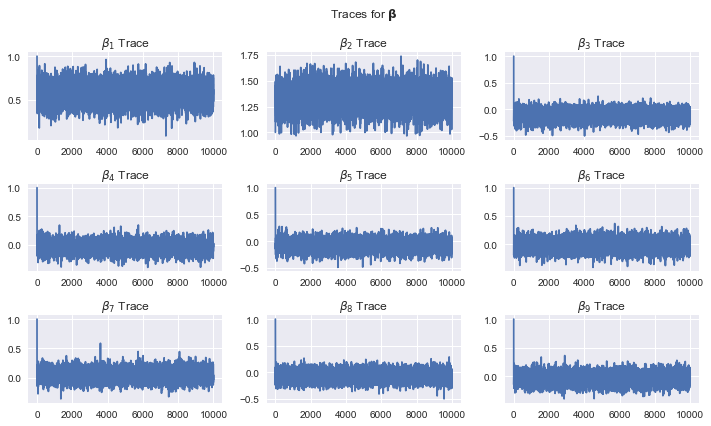

In [207]:
# Trace Plots for the Beta
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(10,6))

for i in range(1,4):
    for j in range(1,4):
        ax[i-1][j-1].plot(beta_tracesLamCV[:,3*(i-1)+j-1])
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{3*(i-1)+j}}}$ Trace")

fig.suptitle(r"Traces for $\mathbf{\beta}$",x=0.51) 
plt.tight_layout()
plt.show()
# Again a burn in of 1000 seems good

In [208]:
burned_BetaLamCV = beta_tracesLamCV[2000:,:]
burned_Sig2LamCV = sig2_tracesLamCV[2000:]
burned_Tau2LamCV = tau2_tracesLamCV[2000:,:]
burned_LambdaLamCV = lambda_tracesLamCV[2000:]

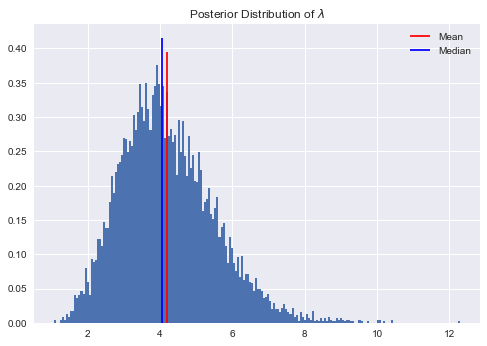

Mean: 4.204987267586769
Median: 4.05436614844327


In [211]:
# Histogram for Lambda

plt.title(r"Posterior Distribution of $\lambda$")
plt.hist(burned_LambdaLamCV,bins=200,density=True)
plt.vlines(np.mean(burned_LambdaLamCV),0,plt.gca().get_ylim()[1],colors="r",label="Mean")
plt.vlines(np.median(burned_LambdaLamCV),0,plt.gca().get_ylim()[1],colors="b",label="Median")
plt.legend(loc="upper right")
plt.show()

print(f"Mean: {np.mean(burned_LambdaLamCV)}")
print(f"Median: {np.median(burned_LambdaLamCV)}")

# Mode roughly the MML estimate

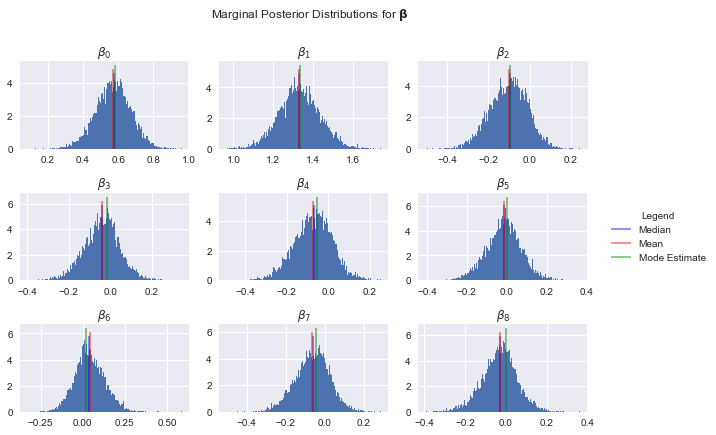

In [231]:
# Histograms for Beta, with medians, means plotted 
# Also plotted the frequentist Lasso estimates that theoretically should be the mode of the posteriors
sigmamedian = np.median(np.sqrt(burned_Sig2LamCV))
lambdamedian = np.median(burned_LambdaLamCV)

smLasso = sm.OLS(y_train-np.mean(y_train),X_train)
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(10,6))

for i in range(1, 4):
    for j in range(1, 4):
        ax[i-1][j-1].hist(burned_BetaLamCV[:,3*(i-1)+j-1],bins=200,density=True)
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{3*(i-1)+j-1}}}$")
        ax[i-1][j-1].vlines(np.median(burned_BetaLamCV,axis=0)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="b",label="Median",alpha=0.5)
        ax[i-1][j-1].vlines(np.mean(burned_BetaLamCV,axis=0)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="r",label="Mean",alpha=0.5)
        ax[i-1][j-1].vlines((smLasso.fit_regularized(alpha=lambdamedian*2*sigmamedian/(2*len(y_train))).params)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="g",label="Mode Estimate",alpha=0.5)
        if ((i==2) and (j==3)):
            ax[i-1][j-1].legend(loc="center right",title="Legend",bbox_to_anchor=(1.75, 0.5))

fig.suptitle(r"Marginal Posterior Distributions for $\mathbf{\beta}$",x=0.435,y=1.0)
plt.tight_layout()
plt.show()

# The symmetric distributions mean that the mode, mean and medians are really close
# But it does look like the frequentist estimates match the empirical mode of the posteriors.

In [232]:
LamCVBetaPosteriorMedians = np.median(burned_BetaLamCV,axis=0)
LamCVBetaPosteriorMedians

array([ 0.5735269 ,  1.32974579, -0.09659237, -0.03810759, -0.06831251,
       -0.011787  ,  0.03674715, -0.05877175, -0.02822387])

23.864888798765232

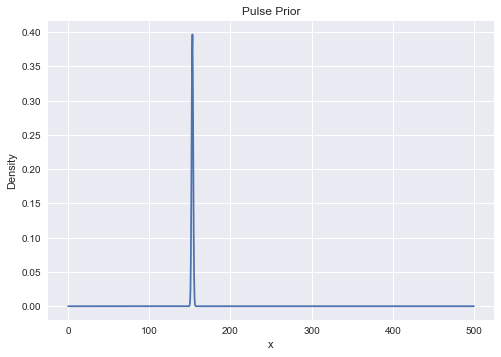

In [233]:
# (4) As before, if we have a lambdaCV, we rescale to get lamCV = lambdaCV/2s
# I propose a "Pulse Prior" with mode at lamCV^{2} and variance dependent on lamCV^{2}
# This way if lamCV is small, the prior is roughly flat - not too different from the naive bayes approach
# if lamCV is large, the prior is a pulse with unit variance around the squared rescaled lambda chosen by CV

# Gamma prior with alpha = 1+lamCV^{4} and beta = lamCV^{2}
# So mode = (alpha-1)/beta = lamCV^{2} and variance = alpha/beta^{2} = 1+(1/lamCV^{4})

lambdaCV = lassoCVmodel.alpha_*2*X_train.shape[0]
s2 = np.sum(smModel.resid**2)/(100-9)
lam = lambdaCV/(2*np.sqrt(s2))

plt.title("Pulse Prior")
plt.plot(np.linspace(0,500,1000),stats.gamma.pdf(np.linspace(0,500,1000),1+lam**4,scale=1/(lam**2)))
plt.ylabel("Density")
plt.xlabel("x")
plt.show()

In [218]:
beta_tracesPulsePrior, sig2_tracesPulsePrior, tau2_tracesPulsePrior, lambda_tracesPulsePrior = bayesianLasso.gibbs_gammaHPrior(r = 1+(lam**4), delta = lam**2, n_iter=10000)

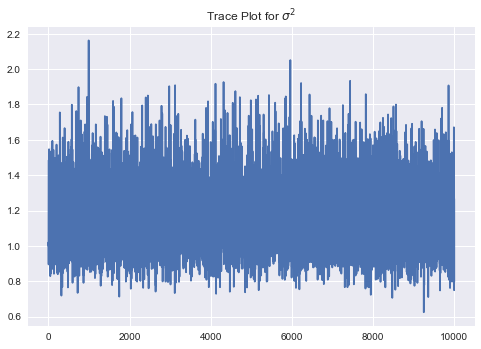

In [219]:
# Trace plot for Sigma^2
plt.title(r"Trace Plot for $\sigma^{2}$")
plt.plot(sig2_tracesPulsePrior)
plt.show()
# A burn in period of 2000 seems sufficient

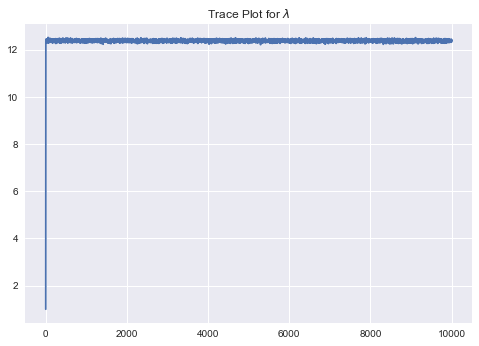

In [220]:
# Trace plot for Lambda
plt.title(r"Trace Plot for $\lambda$")
plt.plot(lambda_tracesPulsePrior)
plt.show()
# A burn in period of 2000 seems sufficient

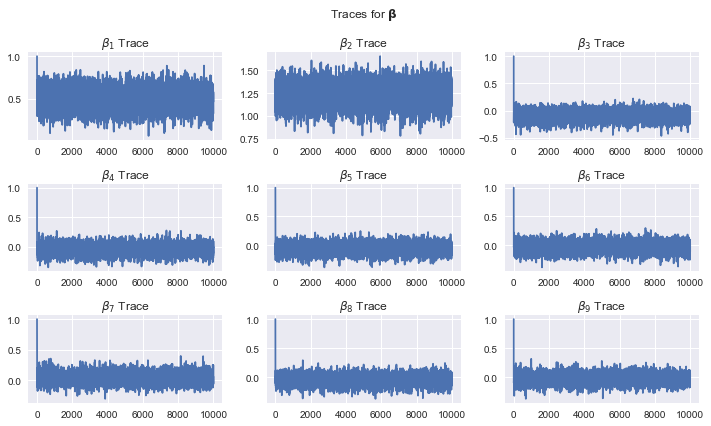

In [221]:
# Trace Plots for the Beta
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(10,6))

for i in range(1,4):
    for j in range(1,4):
        ax[i-1][j-1].plot(beta_tracesPulsePrior[:,3*(i-1)+j-1])
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{3*(i-1)+j}}}$ Trace")

fig.suptitle(r"Traces for $\mathbf{\beta}$",x=0.51) 
plt.tight_layout()
plt.show()
# Again a burn in of 1000 seems good

In [223]:
burned_BetaPulsePrior = beta_tracesPulsePrior[2000:,:]
burned_Sig2PulsePrior = sig2_tracesPulsePrior[2000:]
burned_Tau2PulsePrior = tau2_tracesPulsePrior[2000:,:]
burned_LambdaPulsePrior = lambda_tracesPulsePrior[2000:]

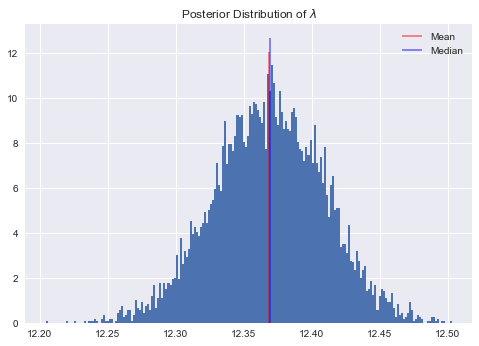

Mean: 12.36850262842575
Median: 12.368897105093676


In [224]:
# Histogram for Lambda

plt.title(r"Posterior Distribution of $\lambda$")
plt.hist(burned_LambdaPulsePrior,bins=200,density=True)
plt.vlines(np.mean(burned_LambdaPulsePrior),0,plt.gca().get_ylim()[1],colors="r",label="Mean",alpha=0.5)
plt.vlines(np.median(burned_LambdaPulsePrior),0,plt.gca().get_ylim()[1],colors="b",label="Median",alpha=0.5)
plt.legend(loc="upper right")
plt.show()

print(f"Mean: {np.mean(burned_LambdaPulsePrior)}")
print(f"Median: {np.median(burned_LambdaPulsePrior)}")

# Mode roughly the MML estimate

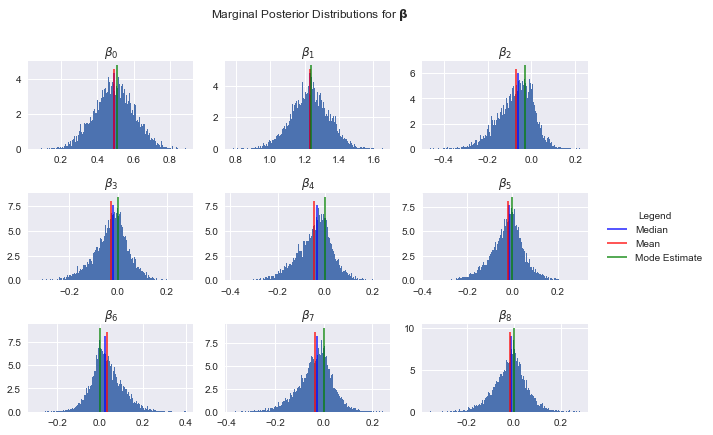

In [226]:
# Histograms for Beta, with medians, means plotted 
# Also plotted the frequentist Lasso estimates that theoretically should be the mode of the posteriors
sigmamedian = np.median(np.sqrt(burned_Sig2PulsePrior))
lambdamedian = np.median(burned_LambdaPulsePrior)

smLasso = sm.OLS(y_train-np.mean(y_train),X_train)
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(10,6))

for i in range(1, 4):
    for j in range(1, 4):
        ax[i-1][j-1].hist(burned_BetaPulsePrior[:,3*(i-1)+j-1],bins=200,density=True)
        ax[i-1][j-1].title.set_text(fr"$\beta_{{{3*(i-1)+j-1}}}$")
        ax[i-1][j-1].vlines(np.median(burned_BetaPulsePrior,axis=0)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="b",label="Median",alpha=0.75)
        ax[i-1][j-1].vlines(np.mean(burned_BetaPulsePrior,axis=0)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="r",label="Mean",alpha=0.75)
        ax[i-1][j-1].vlines((smLasso.fit_regularized(alpha=lambdamedian*2*sigmamedian/(2*len(y_train))).params)[3*(i-1)+j-1],0,ax[i-1][j-1].get_ylim()[1],colors="g",label="Mode Estimate",alpha=0.75)
        if ((i==2) and (j==3)):
            ax[i-1][j-1].legend(loc="center right",title="Legend",bbox_to_anchor=(1.75, 0.5))

fig.suptitle(r"Marginal Posterior Distributions for $\mathbf{\beta}$",x=0.435,y=1.0)
plt.tight_layout()
plt.show()

# The symmetric distributions mean that the mode, mean and medians are really close
# But it does look like the frequentist estimates match the empirical mode of the posteriors.

In [227]:
2*sigmamedian*lambdamedian

26.601337678532424

In [228]:
# (3) The Mode of the exponential is zero, so even though we may specify that the mean of the prior is 20, that is unlikely to reflect in the posterior
# (4) Possible Pareto priors/ Half Cauchy Prior

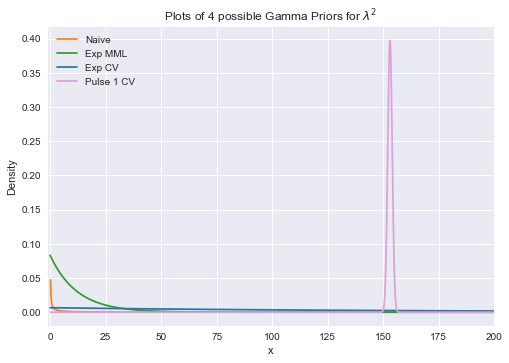

In [254]:
# For purposes of the report, collect graphs of priors here
colors = ["tab:orange","tab:green","tab:blue","plum"]

plt.title(r"Plots of 4 possible Gamma Priors for $\lambda^{2}$")
plt.xlabel("x")
plt.ylabel("Density")

xdom = np.linspace(0,200,1000)
plt.plot(xdom,stats.gamma.pdf(xdom,0.01,scale=1/0.01),color=colors[0],label="Naive") # Naive Gamma Prior
plt.plot(xdom,stats.gamma.pdf(xdom,1,scale=(lambdaMML**2)),color=colors[1],label="Exp MML") # Exponential Prior with Mean = lambdaMML^2
plt.plot(xdom,stats.gamma.pdf(xdom,1,scale=(lam**2)),color=colors[2], label="Exp CV") # Exponential Prior with Mean = LamCV**2
plt.plot(xdom,stats.gamma.pdf(xdom,1+lam**4,scale=1/(lam**2)),color=colors[3], label="Pulse 1 CV") # Pulse Prior

plt.xlim(-1,200)
plt.legend(loc="upper left")
plt.show()


In [264]:
print(np.median(burnedbetatracesCV,axis=0))
print(np.median(burned_BetaPulsePrior,axis=0))


[ 0.49056353  1.23550114 -0.05956809 -0.02072297 -0.03672809 -0.01744999
  0.02361127 -0.027983   -0.01028002]
[ 0.49260607  1.23277936 -0.0613076  -0.0202595  -0.03580137 -0.01672052
  0.02342455 -0.02693523 -0.01074806]


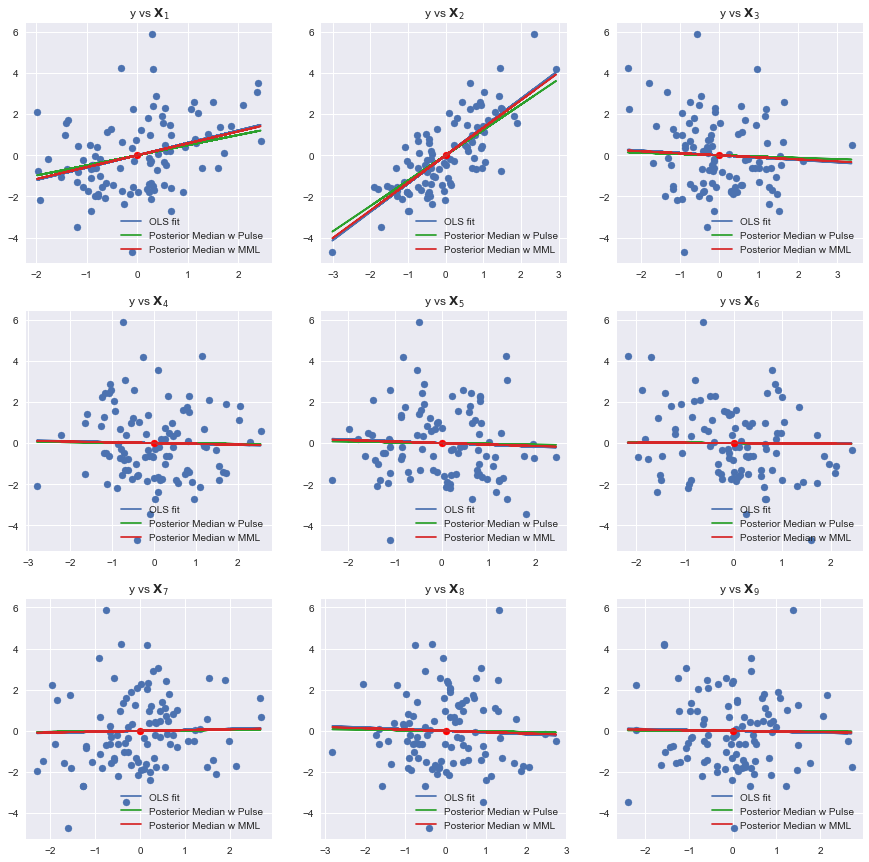

In [274]:
# Superimpose the best fit lines on the graphs
# Add these in report

plt.style.use("seaborn")
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15,15))
for row in range(1,4):
    for column in range(1,4):
        ax[row-1][column-1].scatter(X_train[:,3*(row-1)+column-1],y_train-np.mean(y_train))
        ax[row-1][column-1].plot(X_train[:,3*(row-1)+column-1], smModel.params[3*(row-1)+column-1]*X_train[:,3*(row-1)+column-1], label="OLS fit")
        ax[row-1][column-1].scatter(np.mean(X_train[:,3*(row-1)+column-1]),0,color="r")
        ax[row-1][column-1].plot(X_train[:,3*(row-1)+column-1], np.median(burned_BetaPulsePrior,axis=0)[3*(row-1)+column-1]*X_train[:,3*(row-1)+column-1],color="tab:green", label="Posterior Median w Pulse")
        ax[row-1][column-1].plot(X_train[:,3*(row-1)+column-1], np.median(burnedbetatracesMML,axis=0)[3*(row-1)+column-1]*X_train[:,3*(row-1)+column-1],color="tab:red", label="Posterior Median w MML")
        ax[row-1][column-1].title.set_text(fr"y vs $\mathbf{{X}}_{{{3*(row-1)+column}}}$")
        ax[row-1][column-1].legend(loc="lower right")
plt.show()

y_hat = np.matmul(X_train,np.reshape(smModel.params,(-1,1)))